# First Simple Model to Predict Credit Default

## Read in data, do some cleaning

In [8]:
import pandas as pd
import numpy as np
import pickle

In [3]:
# Read in the data
raw_df = pd.read_csv('credit_data.csv')

# drop unneeded columns
raw_df.drop(columns=['Unnamed: 0'], inplace=True)

# current col names are X1, X2...add better col names
columns = ['Limit','Sex','Education','Marriage','Age','Hist_6',\
           'Hist_5','Hist_4','Hist_3','Hist_2','Hist_1','Bill_6',\
           'Bill_5','Bill_4','Bill_3','Bill_2','Bill_1','Pay_6',\
           'Pay_5','Pay_4','Pay_3','Pay_2','Pay_1','Default']
raw_df.columns = columns

# drop header from first row
raw_df = raw_df.drop([0]).reset_index()

# re-order the columns
columns=['Default','Limit','Sex','Education','Marriage','Age',\
         'Bill_1','Bill_2','Bill_3','Bill_4','Bill_5','Bill_6',\
         'Pay_1','Pay_2','Pay_3','Pay_4','Pay_5','Pay_6',\
         'Hist_1','Hist_2','Hist_3','Hist_4','Hist_5','Hist_6']
raw_df = raw_df[columns]

# replace encoded features with categorical values
raw_df = raw_df.astype(int)
raw_df['Sex'].replace([1,2],['Male','Female'], inplace=True)
raw_df['Education'].replace([0,1,2,3,4,5,6],['Others','Graduate','University','High_School','Others','Others','Others'], inplace=True)
raw_df['Marriage'].replace([0,1,2,3],['Others','Married','Single','Others'], inplace=True)

## Look at class balance

percent default cases = 	22.12%
number non-default cases = 	23364
number default cases = 		6636


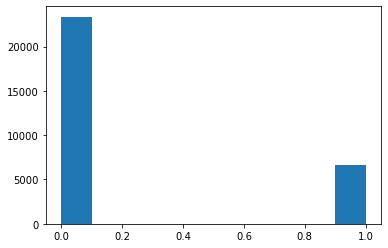

In [4]:
import matplotlib.pyplot as plt
plt.hist(raw_df['Default']);
print('percent default cases = \t{}%'.format(100*(raw_df['Default'] == 1).sum() / len(raw_df)))
print('number non-default cases = \t{}'.format((raw_df['Default'] == 0).sum()))
print('number default cases = \t\t{}'.format((raw_df['Default'] == 1).sum()))

## Split Train, test, val

In [5]:
from sklearn.model_selection import train_test_split

# Separate features from label
X = raw_df.drop(columns='Default')
y = raw_df['Default']

# Hold out 20% test data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4444)

# Hold out 25% of remainder for validation
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=4444)

## Create dummies

In [6]:
# One hot encode categoricals for Train, Val, and Test sets

from sklearn.preprocessing import OneHotEncoder

# Define the categoricals
categoricals = ['Sex','Education','Marriage']

#
# Train data
#
# Initialize
ohe = OneHotEncoder(sparse=False)
# Create a matrix of encoded variables
cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])
# Turn the matrix into a dataframe
X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), # use real column names
                           index=X_train.index) # get index position form training data
# Combine encoded categoricals with the numeric training data
X_train_preprocessed = pd.concat([X_train.drop(columns=categoricals), X_train_ohe], axis=1)

#
# Val data 
#
ohe = OneHotEncoder(sparse=False)
cat_matrix_val = ohe.fit_transform(x_val.loc[:, categoricals])
x_val_ohe = pd.DataFrame(cat_matrix_val,
                           columns=ohe.get_feature_names(categoricals),
                           index=x_val.index)
x_val_preprocessed = pd.concat([x_val.drop(columns=categoricals), x_val_ohe], axis=1)

#
# Test data
#
ohe = OneHotEncoder(sparse=False)
cat_matrix_test = ohe.fit_transform(x_test.loc[:, categoricals])
x_test_ohe = pd.DataFrame(cat_matrix_test,
                           columns=ohe.get_feature_names(categoricals),
                           index=x_test.index)
x_test_preprocessed = pd.concat([x_test.drop(columns=categoricals), x_test_ohe], axis=1)

## Scale

In [6]:
# Scale data for KNN and SVC models
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_preprocessed)
X_train_preprocessed_scaled = scaler.transform(X_train_preprocessed)
x_val_preprocessed_scaled = scaler.transform(x_val_preprocessed)
x_test_preprocessed_scaled = scaler.transform(x_test_preprocessed)

## KNN (k: 1-20)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_val=[]
acc_val=[]
prec_val=[]
rec_val=[]

# Test a bunch of k values
for k in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_preprocessed_scaled, y_train)
    pred = knn.predict(x_val_preprocessed_scaled)
    k_val.append(k)
    acc_val.append(metrics.accuracy_score(y_val, pred))
    prec_val.append(metrics.precision_score(y_val, pred))
    rec_val.append(metrics.recall_score(y_val, pred))

# Put the scores into a df
knn_val_scores = pd.DataFrame(list(zip(k_val, acc_val, prec_val, rec_val)),\
                              columns=['k','acc', 'prec', 'rec'])

In [8]:
import pickle

# Pickle the knn scores
with open('knn_val_FSM.pickle', 'wb') as to_write:
    pickle.dump(knn_val_scores, to_write)

In [9]:
# Read
import pickle
with open('knn_val_FSM.pickle','rb') as read_file:
    knn_val_scores = pickle.load(read_file)

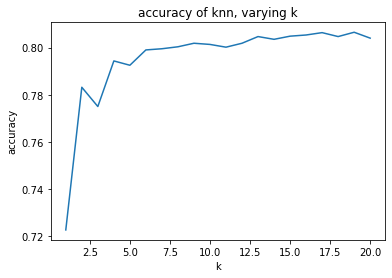

In [10]:
# Visualize the accuracy scores for different k values
plt.plot(knn_val_scores['k'],\
             knn_val_scores['acc'])
plt.title('accuracy of knn, varying k')
plt.ylabel('accuracy')
plt.xlabel('k');

In [11]:
# Pick out k with highest accuracy
max_k = int(knn_val_scores.iloc[np.argmax(knn_val_scores['acc'])].k)

# Build 6 basic models

In [12]:

model_list = []
scores_list = []
fit_models = []

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=max_k)
knn.fit(X_train_preprocessed_scaled, y_train)
knn_score = knn.score(x_val_preprocessed_scaled,y_val)
model_list.append('KNN')
scores_list.append(knn_score)
fit_models.append(knn)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_preprocessed, y_train)
lr_score = lr.score(x_val_preprocessed,y_val)
model_list.append('LR')
scores_list.append(lr_score)
fit_models.append(lr)

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_preprocessed, y_train)
nb_score = nb.score(x_val_preprocessed,y_val)
model_list.append('NB')
scores_list.append(nb_score)
fit_models.append(nb)

from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(X_train_preprocessed_scaled, y_train)
svc_score = svc.score(x_val_preprocessed_scaled,y_val)
model_list.append('SVC')
scores_list.append(svc_score)
fit_models.append(svc)
                           
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_preprocessed, y_train)
dt_score = dt.score(x_val_preprocessed,y_val)
model_list.append('DT')
scores_list.append(dt_score)
fit_models.append(dt)
                           
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_preprocessed, y_train)
rf_score = rf.score(x_val_preprocessed,y_val)
model_list.append('RF')
scores_list.append(rf_score)
fit_models.append(rf)
                           
six_basic_models_val = pd.DataFrame(list(zip(model_list, scores_list)),\
                              columns=['model','acc'])


/Users/Jay/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
#pickle the scores

with open('six_models_FSM.pickle', 'wb') as to_write:
    pickle.dump(six_basic_models_val, to_write)

In [14]:
# pickle the models

with open('six_fit_models_FSM.pickle', 'wb') as to_write:
    pickle.dump(fit_models, to_write)

In [9]:
# Read in the model scores

with open('six_models_FSM.pickle','rb') as read_file:
    six_basic_models_val = pickle.load(read_file)

In [10]:
# Read in the fit models

with open('six_fit_models_FSM.pickle','rb') as read_file:
    fit_models = pickle.load(read_file)
    
# Unpack the pickled models:
knn = fit_models[0]
lr = fit_models[1]
nb = fit_models[2]
svc = fit_models[3]
dt = fit_models[4]
rf = fit_models[5]

# Assess performance of the models on validation data

In [11]:
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, classification_report, recall_score, precision_score, accuracy_score

## KNN

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      4639
           1       0.66      0.30      0.41      1361

    accuracy                           0.81      6000
   macro avg       0.74      0.63      0.65      6000
weighted avg       0.79      0.81      0.78      6000



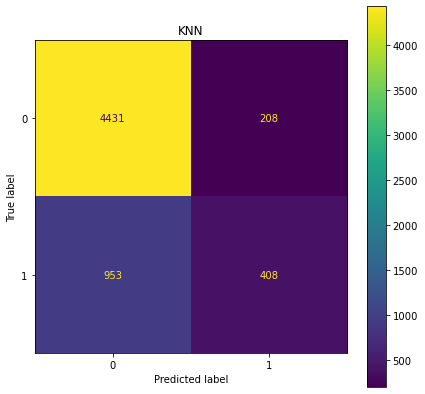

In [18]:
# Make predictions
y_preds = knn.predict(x_val_preprocessed_scaled)
# Assess classification
print(classification_report(y_val, y_preds))
# Build confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, x_val_preprocessed_scaled, y_val, ax=ax)
plt.title('KNN');
# save scores
knn_recall = recall_score(y_val, knn.predict(x_val_preprocessed_scaled))
knn_precision = precision_score(y_val, knn.predict(x_val_preprocessed_scaled))
knn_accuracy = accuracy_score(y_val, knn.predict(x_val_preprocessed_scaled))

## LR

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4639
           1       0.50      0.00      0.00      1361

    accuracy                           0.77      6000
   macro avg       0.64      0.50      0.44      6000
weighted avg       0.71      0.77      0.67      6000



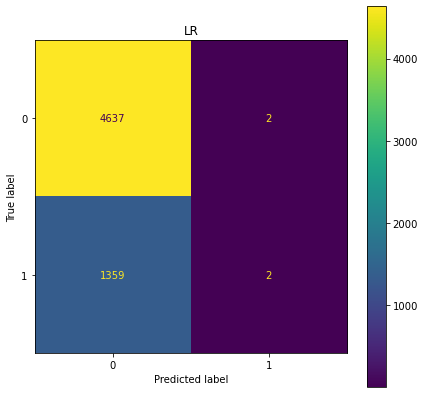

In [19]:
y_preds = lr.predict(x_val_preprocessed)
print(classification_report(y_val, y_preds))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, x_val_preprocessed, y_val, ax=ax)
plt.title('LR');
lr_recall = recall_score(y_val, lr.predict(x_val_preprocessed))
lr_precision = precision_score(y_val, lr.predict(x_val_preprocessed))
lr_accuracy = accuracy_score(y_val, lr.predict(x_val_preprocessed))

## NB

              precision    recall  f1-score   support

           0       0.87      0.22      0.35      4639
           1       0.25      0.89      0.39      1361

    accuracy                           0.37      6000
   macro avg       0.56      0.55      0.37      6000
weighted avg       0.73      0.37      0.36      6000



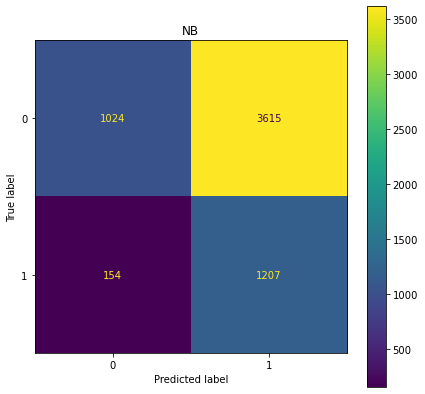

In [20]:
y_preds = nb.predict(x_val_preprocessed)
print(classification_report(y_val, y_preds))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(nb, x_val_preprocessed, y_val, ax=ax)
plt.title('NB');
nb_recall = recall_score(y_val, nb.predict(x_val_preprocessed))
nb_precision = precision_score(y_val, nb.predict(x_val_preprocessed))
nb_accuracy = accuracy_score(y_val, nb.predict(x_val_preprocessed))

## SVC

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4639
           1       0.70      0.34      0.46      1361

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000



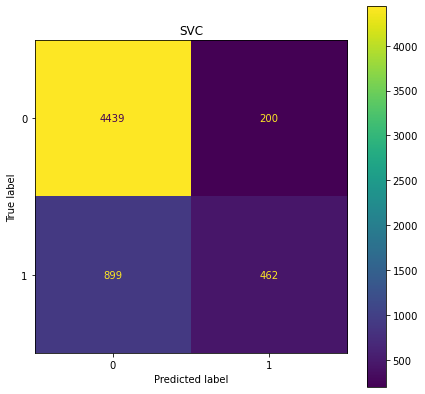

In [21]:
y_preds =svc.predict(x_val_preprocessed_scaled)
print(classification_report(y_val, y_preds))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(svc, x_val_preprocessed_scaled, y_val, ax=ax)
plt.title('SVC');
svc_recall = recall_score(y_val, svc.predict(x_val_preprocessed_scaled))
svc_precision = precision_score(y_val, svc.predict(x_val_preprocessed_scaled))
svc_accuracy = accuracy_score(y_val, svc.predict(x_val_preprocessed_scaled))

## DT

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      4639
           1       0.41      0.42      0.41      1361

    accuracy                           0.73      6000
   macro avg       0.62      0.62      0.62      6000
weighted avg       0.73      0.73      0.73      6000



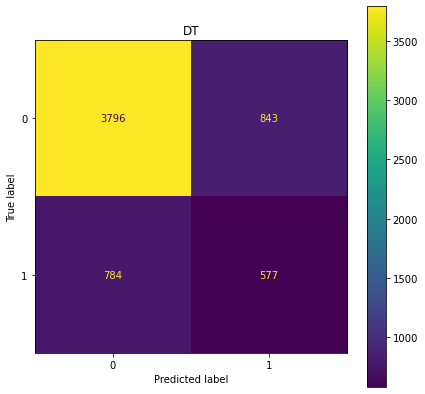

In [22]:
y_preds =dt.predict(x_val_preprocessed)
print(classification_report(y_val, y_preds))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(dt, x_val_preprocessed, y_val, ax=ax)
plt.title('DT');
dt_recall = recall_score(y_val, dt.predict(x_val_preprocessed))
dt_precision = precision_score(y_val, dt.predict(x_val_preprocessed))
dt_accuracy = accuracy_score(y_val, dt.predict(x_val_preprocessed))

## RF

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4639
           1       0.65      0.40      0.49      1361

    accuracy                           0.81      6000
   macro avg       0.74      0.67      0.69      6000
weighted avg       0.80      0.81      0.80      6000



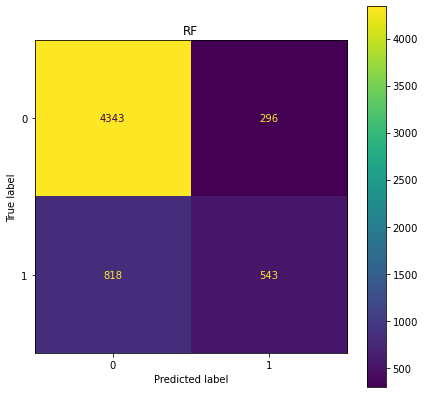

In [23]:
y_preds =rf.predict(x_val_preprocessed)
print(classification_report(y_val, y_preds))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(rf, x_val_preprocessed, y_val, ax=ax)
plt.title('RF');
rf_recall = recall_score(y_val, rf.predict(x_val_preprocessed))
rf_precision = precision_score(y_val, rf.predict(x_val_preprocessed))
rf_accuracy = accuracy_score(y_val, rf.predict(x_val_preprocessed))

# Build Summary Figures

## Accuracy, precision, and recall for each model

In [24]:
# Put model metics into a dataframe
model_names = ['knn','lr','nb','svc','dt','rf']
recall = [knn_recall, lr_recall, nb_recall, svc_recall, dt_recall, rf_recall]
precision = [knn_precision, lr_precision, nb_precision, svc_precision, dt_precision, rf_precision]
accuracy = [knn_accuracy, lr_accuracy, nb_accuracy, svc_accuracy, dt_accuracy, rf_accuracy]

model_metrics = pd.DataFrame(list(zip(model_names, recall, precision, accuracy)),\
                             columns = ['model','recall','precision','accuracy'])

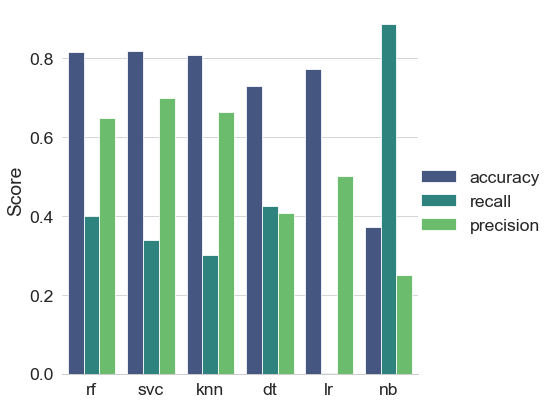

In [25]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=2) 

data = pd.melt(model_metrics, id_vars='model')
data['sort_val'] = data['model']
data['sort_val'] = data['model'].replace(['rf','svc','knn','dt','lr','nb'],[1,2,3,4,5,6])
data = data.sort_values(by='variable').sort_values(by='sort_val')
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=data, kind="bar",
    x="model", y="value", hue="variable",
    ci="sd", palette="viridis", alpha=1, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Score")
g.legend.set_title("")

## ROC AUC Plot

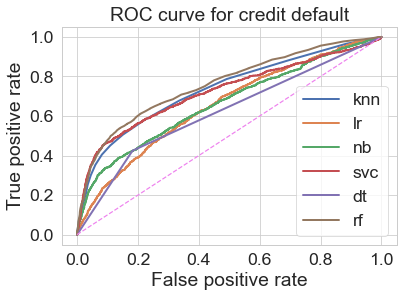

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate false pos and true pos rates for each model
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_val, knn.predict_proba(x_val_preprocessed_scaled)[:,1])
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_val, lr.predict_proba(x_val_preprocessed)[:,1])
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_val, nb.predict_proba(x_val_preprocessed)[:,1])
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_val, svc.predict_proba(x_val_preprocessed_scaled)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_val, dt.predict_proba(x_val_preprocessed)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val, rf.predict_proba(x_val_preprocessed)[:,1])

# Plot ROC for each model
plt.plot(knn_fpr, knn_tpr,lw=2, label='knn')
plt.plot(lr_fpr, lr_tpr,lw=2, label='lr')
plt.plot(nb_fpr, nb_tpr,lw=2, label='nb')
plt.plot(svc_fpr, svc_tpr,lw=2, label='svc')
plt.plot(dt_fpr, dt_tpr,lw=2, label='dt')
plt.plot(rf_fpr, rf_tpr,lw=2, label='rf')

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for credit default');

In [28]:
# Print ROC AUC for each model
print("Model \t ROC AUC")
print("KNN \t {:.2f}".format(roc_auc_score(y_val, knn.predict_proba(x_val_preprocessed_scaled)[:,1])))
print("LR \t {:.2f}".format(roc_auc_score(y_val, lr.predict_proba(x_val_preprocessed)[:,1])))
print("NB \t {:.2f}".format(roc_auc_score(y_val, nb.predict_proba(x_val_preprocessed)[:,1])))
print("SVC \t {:.2f}".format(roc_auc_score(y_val, svc.predict_proba(x_val_preprocessed_scaled)[:,1])))
print("DT \t {:.2f}".format(roc_auc_score(y_val, dt.predict_proba(x_val_preprocessed)[:,1])))
print("RF \t {:.2f}".format(roc_auc_score(y_val, rf.predict_proba(x_val_preprocessed)[:,1])))

Model 	 ROC AUC
KNN 	 0.74
LR 	 0.65
NB 	 0.66
SVC 	 0.72
DT 	 0.62
RF 	 0.76


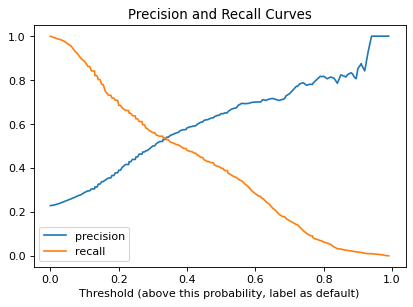

In [12]:
# Plot precision and recall curves for the FR model
from sklearn.metrics import precision_recall_curve, confusion_matrix
precision_curve, recall_curve, threshold_curve = \
precision_recall_curve(y_val, rf.predict_proba(x_val_preprocessed)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as default)');
plt.title('Precision and Recall Curves');

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      4639
           1       0.54      0.53      0.53      1361

    accuracy                           0.79      6000
   macro avg       0.70      0.70      0.70      6000
weighted avg       0.79      0.79      0.79      6000



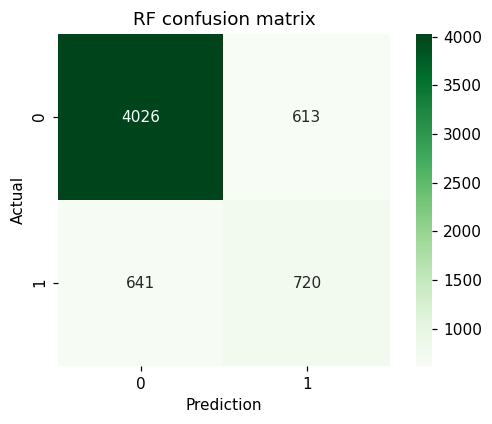

In [13]:
# This is the updated threshold where precision and recall cross over
threshold = threshold_curve[np.argmin(abs(precision_curve - recall_curve))]
y_preds = (rf.predict_proba(x_val_preprocessed)[:, 1] > threshold)
print(classification_report(y_val, y_preds))

import seaborn as sns
cf_matrix = confusion_matrix(y_val, y_preds)
plt.figure(dpi=110)
sns.heatmap(cf_matrix, cmap=plt.cm.Greens, annot=True, square=True, fmt='g',
           xticklabels=[0,1],
           yticklabels=[0,1])

plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('RF confusion matrix');

# Look at distribution of bill/ credit limit for two classes

In [16]:
# Create columns with bill as fraction of credit limit
raw_df['Bill_1_frac'] = raw_df['Bill_1'] / raw_df['Limit']
raw_df['Bill_2_frac'] = raw_df['Bill_2'] / raw_df['Limit']
raw_df['Bill_3_frac'] = raw_df['Bill_3'] / raw_df['Limit']
raw_df['Bill_4_frac'] = raw_df['Bill_4'] / raw_df['Limit']
raw_df['Bill_5_frac'] = raw_df['Bill_5'] / raw_df['Limit']
raw_df['Bill_6_frac'] = raw_df['Bill_6'] / raw_df['Limit']
raw_df['sum_frac_cl'] = raw_df['Bill_1_frac'] + raw_df['Bill_2_frac'] +\
raw_df['Bill_3_frac'] + raw_df['Bill_4_frac'] + raw_df['Bill_5_frac'] + raw_df['Bill_6_frac']

# parse indices for default vs no default cases:
def_ind = raw_df.index[raw_df['Default']==1]
nodef_ind = raw_df.index[raw_df['Default']==0]

# get a random sample of n default cases, where n = num no-default cases
import random
random.seed(1)
upsampled_ind = random.choices(def_ind, k=len(nodef_ind))

# make a df with the no-default cases
new_df = raw_df.iloc[nodef_ind]

# append the new_df with the upsampled default cases
new_df = new_df.append(raw_df.iloc[upsampled_ind])

# clean
new_df = new_df.reset_index()
new_df.drop(columns='index', inplace=True)

default_df = new_df[new_df['Default']==1]
nodefault_df = new_df[new_df['Default']==0]

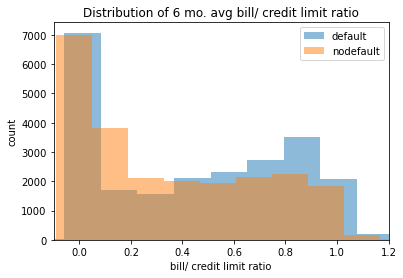

In [18]:
plt.hist(default_df['sum_frac_cl']/6, bins=20, alpha=0.5, label='default')
plt.hist(nodefault_df['sum_frac_cl']/6, bins=40, alpha=0.5, label='nodefault')
plt.xlim([-.1,1.2])
plt.xlabel('bill/ credit limit ratio')
plt.ylabel('count')
plt.title('Distribution of 6 mo. avg bill/ credit limit ratio')
plt.legend();